In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.patches as mpatches
from scipy.stats import ttest_ind, ttest_1samp, ttest_rel
import matplotlib as mpl
import matplotlib.patches as mpatches
from statsmodels.stats.multitest import multipletests

In [3]:
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
sns.set_palette("Dark2")

In [4]:
def deep_learning_cv_score(df):
    scores_cv_long = []
    for i in range(5):
        scores_multi_protein_cv_c = df[
            df['run'] == f'cv_{i}'].reset_index(drop=True)

        max_epoch = scores_multi_protein_cv_c.groupby(
            ['epoch']).median()['val_score'].reset_index()
        max_epoch = np.squeeze(max_epoch[max_epoch['val_score'] ==
                                         max_epoch['val_score'].max()]['epoch'])
        scores_cv_long.append(df[
            (df['run'] == f'cv_{i}')
            & (df['epoch'] == max_epoch)].reset_index(drop=True))
    scores_cv_long = pd.concat(scores_cv_long).drop(['epoch', 'mae'], axis=1)
    scores_cv_long['model'] = 'DL'
    return scores_cv_long

In [5]:
colour_list = pd.read_csv('../data/colour_list.txt',header=None)[0].tolist()

In [6]:
drug_info = pd.read_csv("../data/drug/drug_info.csv")
fda_drugs = drug_info[drug_info['FDA_Approved']=='Yes']['drug_id'].values

In [7]:
target_pathway_map = drug_info.set_index(['drug_id']).to_dict()['target_pathway']

In [8]:
drug_colours = dict(
    zip(drug_info['target_pathway'].unique(),
        colour_list[:drug_info['target_pathway'].unique().size]))

# ln_IC50

## test set

### model comparison

In [101]:
test_df_protein_list = []
col = ['drug_id', 'test_corr']

scores_en_protein = pd.read_csv("../work_dirs/protein/ElasticNet/scores_202006201223_ruv_min_300_eg_id.csv")[col]
scores_en_protein['model'] = 'ENet'
scores_en_protein['data'] = 'protein'

scores_rf_protein = pd.read_csv(
    "../work_dirs/protein/RandomForest/scores_202006181311_ruv_min_300_eg_id.csv")[col]
scores_rf_protein['model'] = 'RF'
scores_rf_protein['data'] = 'protein'
tmp_df = pd.concat([scores_en_protein, scores_rf_protein])
test_df_protein_list.append(tmp_df)

scores_multi_protein = pd.read_csv(
    "../work_dirs/protein/MultiDrug/scores_202006191021_resx_ruv_zero_300_eg_id.csv"
)
scores_multi_protein_test = scores_multi_protein[
    scores_multi_protein['run'] == 'test'].reset_index(drop=True).rename(
        columns={'corr': 'test_corr'})
tmp_df = scores_multi_protein_test[scores_multi_protein_test['epoch']
                                        == 70][col].reset_index(drop=True)
tmp_df['model'] = 'DL'
tmp_df['data'] = 'protein'
test_df_protein_list.append(tmp_df)

test_corr_df_protein = pd.concat(test_df_protein_list)
test_corr_df_protein['key'] = test_corr_df_protein.apply(lambda row:f"{row['data']} + {row['model']}", axis=1)

In [102]:
test_df_rna_list = []
col = ['drug_id', 'test_corr']

scores_en_rna = pd.read_csv("../work_dirs/rna/ElasticNet/scores_202006201358_rna_300_eg_id.csv")[col]
scores_en_rna['model'] = 'ENet'
scores_en_rna['data'] = 'RNA'

scores_rf_rna = pd.read_csv(
    "../work_dirs/rna/RandomForest/scores_202006191030_rna_300_eg_id.csv")[col]
scores_rf_rna['model'] = 'RF'
scores_rf_rna['data'] = 'RNA'
tmp_df = pd.concat([scores_en_rna, scores_rf_rna])
test_df_rna_list.append(tmp_df)

scores_multi_rna = pd.read_csv(
    "../work_dirs/rna/MultiDrug/scores_202006181624_res_eg_id.csv"
)
scores_multi_rna_test = scores_multi_rna[
    scores_multi_rna['run'] == 'test'].reset_index(drop=True).rename(
        columns={'corr': 'test_corr'})
tmp_df = scores_multi_rna_test[scores_multi_rna_test['epoch']
                                        == 240][col].reset_index(drop=True)
tmp_df['model'] = 'DL'
tmp_df['data'] = 'RNA'
test_df_rna_list.append(tmp_df)

test_corr_df_rna = pd.concat(test_df_rna_list)
test_corr_df_rna['key'] = test_corr_df_rna.apply(lambda row:f"{row['data']} + {row['model']}", axis=1)

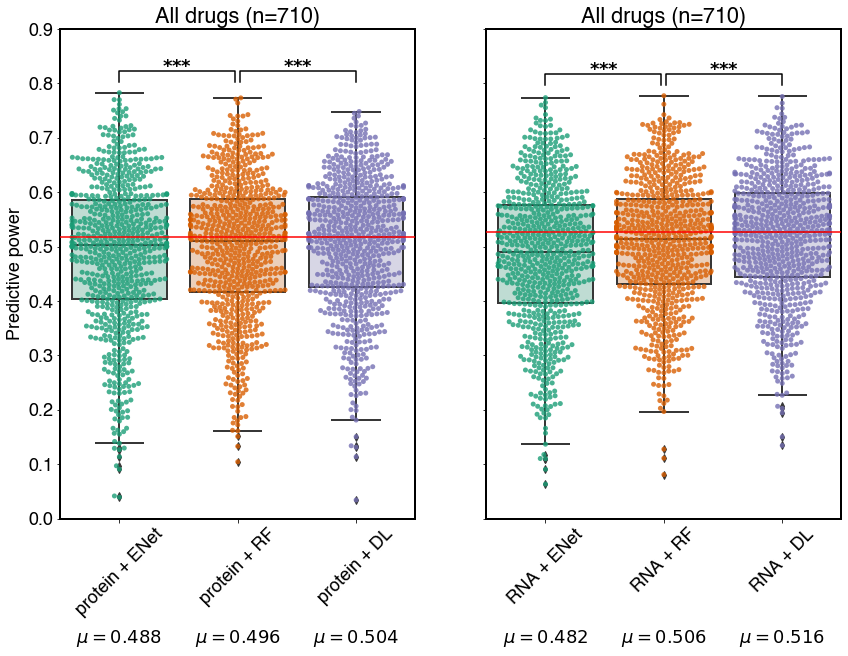

In [103]:
fig, ax = plt.subplots(1, 2, figsize=(14, 10), sharey=True)
ga = sns.boxplot('key',
                 'test_corr',
                 data=test_corr_df_protein,
                 orient='v',
                 linewidth=2,
                 ax=ax[0])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))

sns.swarmplot('key',
              'test_corr',
              data=test_corr_df_protein,
              orient='vh',
              alpha=.8,
              ax=ax[0])

x1, x2 = 0, 0.98  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = test_corr_df_protein['test_corr'].max() + 0.02, 0.02, 'k'
ax[0].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[0].text((x1 + x2) * .5,
           y + w + 0.01,
           r"$\bf{*}\bf{*}\bf{*}$",
           ha='center',
           va='center',
           color=col)
x1, x2 = 1.02, 2  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = test_corr_df_protein['test_corr'].max() + 0.02, 0.02, 'k'
ax[0].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[0].text((x1 + x2) * .5,
           y + w + 0.01,
           r"$\bf{*}\bf{*}\bf{*}$",
           ha='center',
           va='center',
           color=col)
y = test_corr_df_protein[test_corr_df_protein['key'] ==
                         'protein + DL']['test_corr'].median()
ax[0].plot((-0.5, 2.5), [y, y], color='red', zorder=10)
ax[0].text(
    0,
    -0.22,
    f"$\mu={test_corr_df_protein[test_corr_df_protein['key']=='protein + ENet']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')
ax[0].text(
    1,
    -0.22,
    f"$\mu={test_corr_df_protein[test_corr_df_protein['key']=='protein + RF']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')
ax[0].text(
    2,
    -0.22,
    f"$\mu={test_corr_df_protein[test_corr_df_protein['key']=='protein + DL']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')

# RNA
ga = sns.boxplot('key',
                 'test_corr',
                 data=test_corr_df_rna,
                 orient='v',
                 linewidth=2,
                 ax=ax[1])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))

sns.swarmplot('key',
              'test_corr',
              data=test_corr_df_rna,
              orient='vh',
              alpha=.8,
              ax=ax[1])

x1, x2 = 0, 0.98  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = test_corr_df_rna['test_corr'].max() + 0.02, 0.02, 'k'
ax[1].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[1].text((x1 + x2) * .5,
           y + w + 0.01,
           r"$\bf{*}\bf{*}\bf{*}$",
           ha='center',
           va='center',
           color=col)
x1, x2 = 1.02, 2  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = test_corr_df_rna['test_corr'].max() + 0.02, 0.02, 'k'
ax[1].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[1].text((x1 + x2) * .5,
           y + w + 0.01,
           r"$\bf{*}\bf{*}\bf{*}$",
           ha='center',
           va='center',
           color=col)
y = test_corr_df_rna[test_corr_df_rna['key'] ==
                     'RNA + DL']['test_corr'].median()
ax[1].plot((-0.5, 2.5), [y, y], color='red', zorder=10)
ax[1].text(
    0,
    -0.22,
    f"$\mu={test_corr_df_rna[test_corr_df_rna['key']=='RNA + ENet']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')
ax[1].text(
    1,
    -0.22,
    f"$\mu={test_corr_df_rna[test_corr_df_rna['key']=='RNA + RF']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')
ax[1].text(
    2,
    -0.22,
    f"$\mu={test_corr_df_rna[test_corr_df_rna['key']=='RNA + DL']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')

ax[0].set_ylabel('Predictive power')
ax[0].set_xlabel('')
ax[0].set_title(f'All drugs (n={test_corr_df_rna["drug_id"].unique().size})')
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_title(f'All drugs (n={test_corr_df_rna["drug_id"].unique().size})')
plt.ylim(0, .9)
fig.autofmt_xdate(rotation=45, ha='center')
# plt.savefig("../plots/drug/Fig4C.pdf", dpi=500)

In [104]:
ttest_rel(test_corr_df_rna[test_corr_df_rna['key']=='RNA + ENet']['test_corr'].values,
          test_corr_df_rna[test_corr_df_rna['key']=='RNA + RF']['test_corr'].values)

Ttest_relResult(statistic=-13.116987306032057, pvalue=2.3939061839250466e-35)

In [105]:
ttest_rel(test_corr_df_protein[test_corr_df_protein['key']=='protein + ENet']['test_corr'].values,
          test_corr_df_protein[test_corr_df_protein['key']=='protein + RF']['test_corr'].values)

Ttest_relResult(statistic=-4.613443638453064, pvalue=4.699777121908845e-06)

In [106]:
ttest_rel(test_corr_df_rna[test_corr_df_rna['key']=='RNA + RF']['test_corr'].values,
          test_corr_df_rna[test_corr_df_rna['key']=='RNA + DL']['test_corr'].values)

Ttest_relResult(statistic=-6.05482553622258, pvalue=2.278779462462009e-09)

In [107]:
ttest_rel(test_corr_df_protein[test_corr_df_protein['key']=='protein + RF']['test_corr'].values,
          test_corr_df_protein[test_corr_df_protein['key']=='protein + DL']['test_corr'].values)

Ttest_relResult(statistic=-4.628303616538436, pvalue=4.38409021608198e-06)

### data comparison

In [108]:
col = ['drug_id', 'test_corr']

In [109]:
test_corr_df_en = pd.concat([scores_en_protein, scores_en_rna])

test_corr_df_en['key'] = test_corr_df_en.apply(lambda row:f"{row['data']} + {row['model']}", axis=1)

In [110]:
test_corr_df_rf = pd.concat([scores_rf_protein, scores_rf_rna])

test_corr_df_rf['key'] = test_corr_df_rf.apply(lambda row:f"{row['data']} + {row['model']}", axis=1)

In [111]:
protein_df = scores_multi_protein_test[scores_multi_protein_test['epoch']
                                        == 70][col].reset_index(drop=True)
protein_df['model'] = 'DL'
protein_df['data'] = 'protein'

rna_df = scores_multi_rna_test[scores_multi_rna_test['epoch']
                                        == 210][col].reset_index(drop=True)
rna_df['model'] = 'DL'
rna_df['data'] = 'RNA'
test_corr_df_dl = pd.concat([protein_df, rna_df])

test_corr_df_dl['key'] = test_corr_df_dl.apply(lambda row:f"{row['data']} + {row['model']}", axis=1)

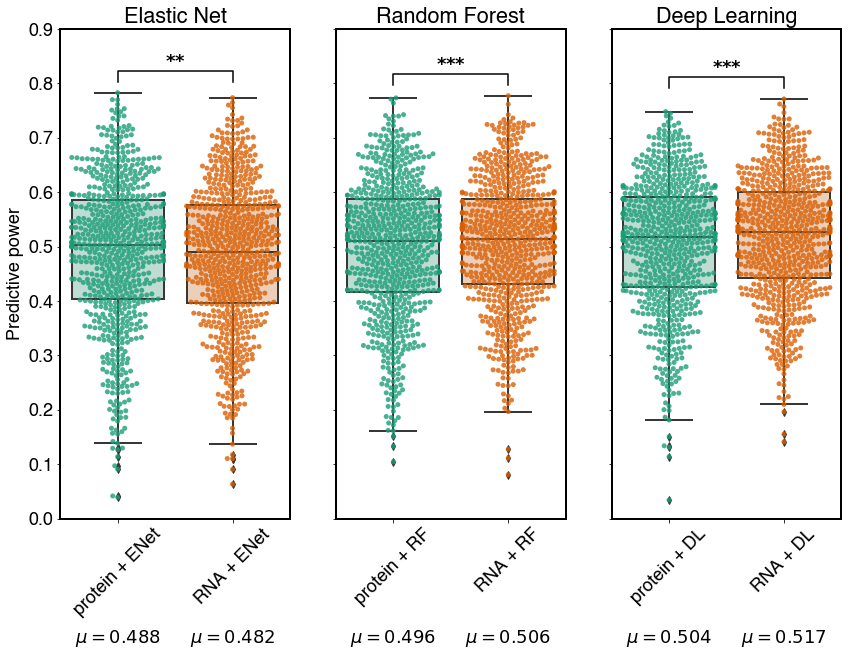

In [112]:
fig, ax = plt.subplots(1, 3, figsize=(14, 10), sharey=True)
# EN
ga = sns.boxplot('key',
            'test_corr',
            data=test_corr_df_en,
            orient='v',
            linewidth=2,
            ax=ax[0])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.swarmplot('key',
              'test_corr',
              data=test_corr_df_en,
              orient='vh',
              alpha=.8,
              ax=ax[0])

x1, x2 = 0, 1  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = test_corr_df_en['test_corr'].max() + 0.02, 0.02, 'k'
ax[0].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[0].text((x1 + x2) * .5,
           y + w + 0.02,
           r"$\bf{*}\bf{*}$",
           ha='center',
           va='center',
           color=col)
ax[0].text(
    0,
    -0.22,
    f"$\mu={test_corr_df_en[test_corr_df_en['key']=='protein + ENet']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')
ax[0].text(
    1,
    -0.22,
    f"$\mu={test_corr_df_en[test_corr_df_en['key']=='RNA + ENet']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')
# RF
ga = sns.boxplot('key',
            'test_corr',
            data=test_corr_df_rf,
            orient='v',
            linewidth=2,
            ax=ax[1])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.swarmplot('key',
              'test_corr',
              data=test_corr_df_rf,
              orient='vh',
              alpha=.8,
              ax=ax[1])

x1, x2 = 0, 1  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = test_corr_df_rf['test_corr'].max() + 0.02, 0.02, 'k'
ax[1].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[1].text((x1 + x2) * .5,
           y + w + 0.02,
           r"$\bf{*}\bf{*}\bf{*}$",
           ha='center',
           va='center',
           color=col)
ax[1].text(
    0,
    -0.22,
    f"$\mu={test_corr_df_rf[test_corr_df_rf['key']=='protein + RF']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')
ax[1].text(
    1,
    -0.22,
    f"$\mu={test_corr_df_rf[test_corr_df_rf['key']=='RNA + RF']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')

# DL
ga = sns.boxplot('key',
            'test_corr',
            data=test_corr_df_dl,
            orient='v',
            linewidth=2,
            ax=ax[2])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.swarmplot('key',
              'test_corr',
              data=test_corr_df_dl,
              orient='vh',
              alpha=.8,
              ax=ax[2])

x1, x2 = 0, 1  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = test_corr_df_dl['test_corr'].max() + 0.02, 0.02, 'k'
ax[2].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[2].text((x1 + x2) * .5,
           y + w + 0.02,
           r"$\bf{*}\bf{*}\bf{*}$",
           ha='center',
           va='center',
           color=col)
ax[2].text(
    0,
    -0.22,
    f"$\mu={test_corr_df_dl[test_corr_df_dl['key']=='protein + DL']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')
ax[2].text(
    1,
    -0.22,
    f"$\mu={test_corr_df_dl[test_corr_df_dl['key']=='RNA + DL']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')

ax[0].set_ylabel('Predictive power')
ax[0].set_xlabel('')
ax[0].set_title('Elastic Net')
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_title('Random Forest')
ax[2].set_ylabel('')
ax[2].set_xlabel('')
ax[2].set_title('Deep Learning')
plt.ylim(0, .9)
fig.autofmt_xdate(rotation=45, ha='center')
# plt.savefig("../plots/drug/Fig4S-B.pdf", dpi=500)

In [113]:
ttest_rel(test_corr_df_en[test_corr_df_en['key']=='protein + ENet']['test_corr'].values,
          test_corr_df_en[test_corr_df_en['key']=='RNA + ENet']['test_corr'].values)

Ttest_relResult(statistic=2.3769994692975622, pvalue=0.017718523030578637)

In [114]:
ttest_rel(test_corr_df_rf[test_corr_df_rf['key']=='protein + RF']['test_corr'].values,
          test_corr_df_rf[test_corr_df_rf['key']=='RNA + RF']['test_corr'].values)

Ttest_relResult(statistic=-5.780074721978192, pvalue=1.1187867724727762e-08)

In [115]:
ttest_rel(test_corr_df_dl[test_corr_df_dl['key']=='protein + DL']['test_corr'].values,
          test_corr_df_dl[test_corr_df_dl['key']=='RNA + DL']['test_corr'].values)

Ttest_relResult(statistic=-7.388355953454975, pvalue=4.191072899161142e-13)

In [116]:
combined_df = pd.concat([test_corr_df_en, test_corr_df_rf, test_corr_df_dl])

In [117]:
combined_df.to_csv("../plots/plot_data/SuppFig8A_rna_vs_protein_box.csv",
                   index=False)

### protein RNA consistency

#### ENet

In [118]:
test_corr_df_en_scatter = pd.pivot(test_corr_df_en, index='drug_id', columns='key', values='test_corr')

In [119]:
test_corr_df_en_scatter['delta'] = test_corr_df_en_scatter[
    'protein + ENet'] - test_corr_df_en_scatter['RNA + ENet']
test_corr_df_en_scatter.sort_values(by='delta', ascending=False).head()

key,RNA + ENet,protein + ENet,delta
drug_id,,,
1945;Taselisib;GDSC2,0.110463,0.365488,0.255025
147;NSC-87877;GDSC1,0.191199,0.389392,0.198193
1518;Lasalocid;GDSC1,0.157162,0.350737,0.193575
2075;EGFR_8897;GDSC2,0.221225,0.410655,0.189430
2509;Taselisib;GDSC2,0.110144,0.287211,0.177068


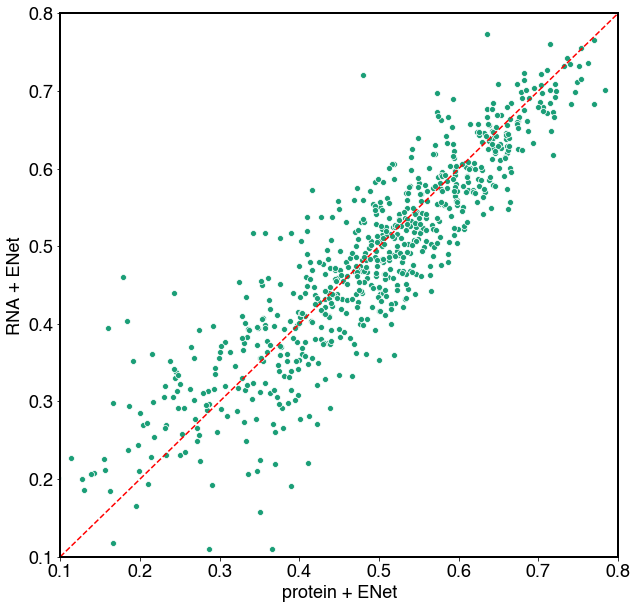

In [120]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x='protein + ENet', y='RNA + ENet', data=test_corr_df_en_scatter)
plt.xlim(0.1,0.8)
plt.ylim(0.1,0.8)
plt.plot((0.1,0.8), (0.1,0.8), ls="--", c='red')
# ax.annotate('Motesanib:RTK signaling',
#             xy=(0.543336, 0.209053), xycoords='data',
#             xytext=(-30, 40), textcoords='offset points',
#             arrowprops=dict(arrowstyle="->"), fontsize=16)

In [121]:
pearsonr(test_corr_df_en_scatter['protein + ENet'], test_corr_df_en_scatter['RNA + ENet'])

(0.894067530655311, 3.833000769210922e-249)

#### RF

In [122]:
test_corr_df_rf_scatter = pd.pivot(test_corr_df_rf, index='drug_id', columns='key', values='test_corr')

In [123]:
test_corr_df_rf_scatter['delta'] = test_corr_df_rf_scatter[
    'protein + RF'] - test_corr_df_rf_scatter['RNA + RF']
test_corr_df_rf_scatter.sort_values(by='delta', ascending=False).head()

key,RNA + RF,protein + RF,delta
drug_id,,,
11;Paclitaxel;GDSC1,0.216966,0.356665,0.139699
2255;RK-33;GDSC2,0.342714,0.479682,0.136969
53;CGP-60474;GDSC1,0.310255,0.444041,0.133786
1149;TW 37;GDSC1,0.349905,0.479116,0.129211
1149;TW 37;GDSC2,0.481172,0.609050,0.127878


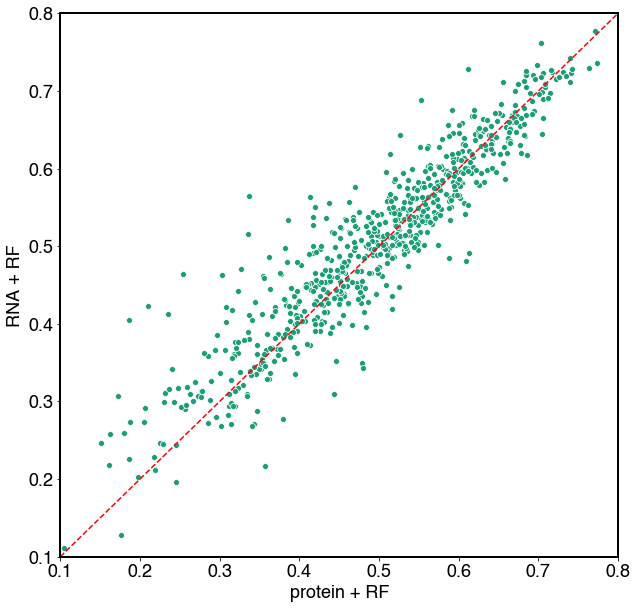

In [124]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x='protein + RF', y='RNA + RF', data=test_corr_df_rf_scatter)
plt.xlim(0.1,0.8)
plt.ylim(0.1,0.8)
plt.plot((0.1,0.8), (0.1,0.8), ls="--", c='red')

In [125]:
pearsonr(test_corr_df_rf_scatter['protein + RF'], test_corr_df_rf_scatter['RNA + RF'])

(0.9298101355558666, 1.450712368116933e-309)

#### DL

In [126]:
test_corr_df_dl_scatter = pd.pivot(test_corr_df_dl, index='drug_id', columns='key', values='test_corr')

In [127]:
test_corr_df_dl_scatter['delta'] = test_corr_df_dl_scatter[
    'protein + DL'] - test_corr_df_dl_scatter['RNA + DL']
test_corr_df_dl_scatter.sort_values(by='delta', ascending=False).head(10)

key,RNA + DL,protein + DL,delta
drug_id,,,
2255;RK-33;GDSC2,0.368966,0.536171,0.167205
1936;Savolitinib;GDSC2,0.517323,0.657922,0.140600
86;A-443654;GDSC1,0.289613,0.413328,0.123715
2220;Regorafenib;GDSC2,0.439782,0.561023,0.121241
1502;Bicalutamide;GDSC1,0.309032,0.428177,0.119145
1243;Piperlongumine;GDSC1,0.403101,0.518065,0.114965
1149;TW 37;GDSC2,0.462174,0.570807,0.108633
1008;Methotrexate;GDSC2,0.527284,0.632947,0.105663
2171;BMS-754807;GDSC2,0.415879,0.520344,0.104466


In [128]:
test_corr_df_dl_scatter.sort_values(by='protein + DL', ascending=False).head(10)

key,RNA + DL,protein + DL,delta
drug_id,,,
2018;PDGFR_5313;GDSC2,0.710283,0.748334,0.038052
1867;Panobinostat;GDSC2,0.724465,0.745106,0.020641
1909;Venetoclax;GDSC2,0.709338,0.740261,0.030924
1946;MIK-665 / S-64315;GDSC2,0.738178,0.736072,-0.002106
2359;GSK2830371;GDSC2,0.771548,0.729034,-0.042514
2127;Mcl1_6386;GDSC2,0.746362,0.727094,-0.019267
1006;Cytarabine;GDSC2,0.762063,0.723308,-0.038755
2243;AZD6738;GDSC2,0.685581,0.722778,0.037197
2153;S63845;GDSC2,0.705406,0.721123,0.015717


Text(0.5, 0, 'Protein predictive power')

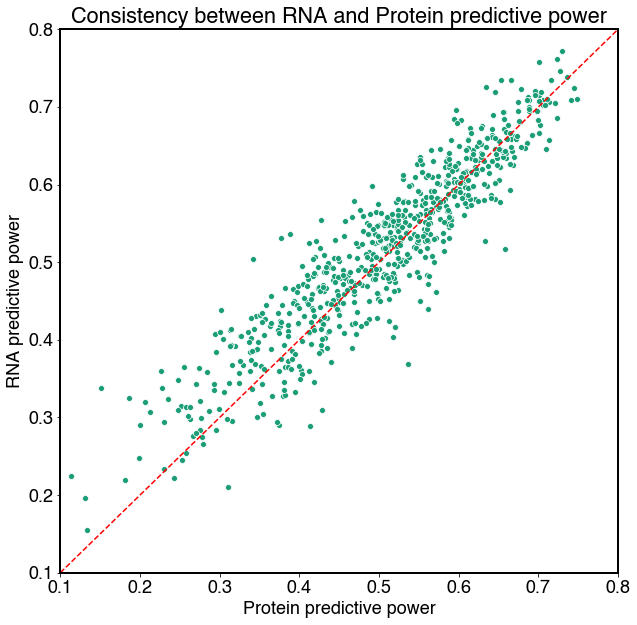

In [129]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x='protein + DL', y='RNA + DL', data=test_corr_df_dl_scatter)
plt.xlim(0.1,0.8)
plt.ylim(0.1,0.8)
plt.plot((0.1,0.8), (0.1,0.8), ls="--", c='red')
plt.title("Consistency between RNA and Protein predictive power")
plt.ylabel("RNA predictive power")
plt.xlabel("Protein predictive power")

# plt.savefig("../plots/drug/Fig4D.pdf", dpi=500)

In [130]:
pearsonr(test_corr_df_dl_scatter['protein + DL'], test_corr_df_dl_scatter['RNA + DL'])

(0.9248469169963414, 1.8707589225363365e-299)

## CV

In [131]:
col = ['drug_id', 'cv0_corr', 'cv1_corr', 'cv2_corr', 'cv3_corr', 'cv4_corr']
scores_en_rna_cv = pd.read_csv(
    "../work_dirs/rna/ElasticNet/scores_202006201358_rna_300_eg_id.csv")[col]
scores_rf_rna_cv = pd.read_csv(
    "../work_dirs/rna/RandomForest/scores_202006191030_rna_300_eg_id.csv")[col]
scores_multi_rna_cv = pd.read_csv(
    "../work_dirs/rna/MultiDrug/scores_202006181624_res_eg_id.csv")

scores_multi_rna_cv = scores_multi_rna_cv[
    scores_multi_rna_cv['run'] != 'test'].reset_index(drop=True).rename(
        columns={'corr': 'val_score'})

In [132]:
col = ['drug_id', 'cv0_corr', 'cv1_corr', 'cv2_corr', 'cv3_corr', 'cv4_corr']
scores_en_protein_cv = pd.read_csv(
    "../work_dirs/protein/ElasticNet/scores_202006201223_ruv_min_300_eg_id.csv")[col]
scores_rf_protein_cv = pd.read_csv(
    "../work_dirs/protein/RandomForest/scores_202006181311_ruv_min_300_eg_id.csv"
)[col]
scores_multi_protein_cv = pd.read_csv(
    "../work_dirs/protein/MultiDrug/scores_202006191021_resx_ruv_zero_300_eg_id.csv")

scores_multi_protein_cv = scores_multi_protein_cv[
    scores_multi_protein_cv['run'] != 'test'].reset_index(drop=True).rename(
        columns={'corr': 'val_score'})

In [133]:
scores_en_protein_cv_long = pd.melt(
    scores_en_protein_cv,
    id_vars='drug_id',
    value_vars=['cv0_corr', 'cv1_corr', 'cv2_corr', 'cv3_corr', 'cv4_corr'],
    var_name='run',
    value_name='val_score')
scores_en_protein_cv_long['model'] = 'ENet'
scores_en_protein_cv_long['data'] = 'protein'


scores_rf_protein_cv_long = pd.melt(
    scores_rf_protein_cv,
    id_vars='drug_id',
    value_vars=['cv0_corr', 'cv1_corr', 'cv2_corr', 'cv3_corr', 'cv4_corr'],
    var_name='run',
    value_name='val_score')
scores_rf_protein_cv_long['model'] = 'RF'
scores_rf_protein_cv_long['data'] = 'protein'

scores_dl_protein_cv_long = deep_learning_cv_score(scores_multi_protein_cv)
scores_dl_protein_cv_long['data'] = 'protein'

In [134]:
scores_en_rna_cv_long = pd.melt(
    scores_en_rna_cv,
    id_vars='drug_id',
    value_vars=['cv0_corr', 'cv1_corr', 'cv2_corr', 'cv3_corr', 'cv4_corr'],
    var_name='run',
    value_name='val_score')
scores_en_rna_cv_long['model'] = 'ENet'
scores_en_rna_cv_long['data'] = 'RNA'

scores_rf_rna_cv_long = pd.melt(
    scores_rf_rna_cv,
    id_vars='drug_id',
    value_vars=['cv0_corr', 'cv1_corr', 'cv2_corr', 'cv3_corr', 'cv4_corr'],
    var_name='run',
    value_name='val_score')
scores_rf_rna_cv_long['model'] = 'RF'
scores_rf_rna_cv_long['data'] = 'RNA'
scores_dl_rna_cv_long = deep_learning_cv_score(scores_multi_rna_cv)
scores_dl_rna_cv_long['data'] = 'RNA'

### performance bar plot

In [135]:
rna_cv_bar = pd.concat([scores_en_rna_cv_long, scores_rf_rna_cv_long, scores_dl_rna_cv_long])
rna_cv_bar['key'] = rna_cv_bar.apply(lambda row:f"{row['data']} + {row['model']}", axis=1)

In [136]:
protein_cv_bar = pd.concat([scores_en_protein_cv_long, scores_rf_protein_cv_long, scores_dl_protein_cv_long])
protein_cv_bar['key'] = protein_cv_bar.apply(lambda row:f"{row['data']} + {row['model']}", axis=1)

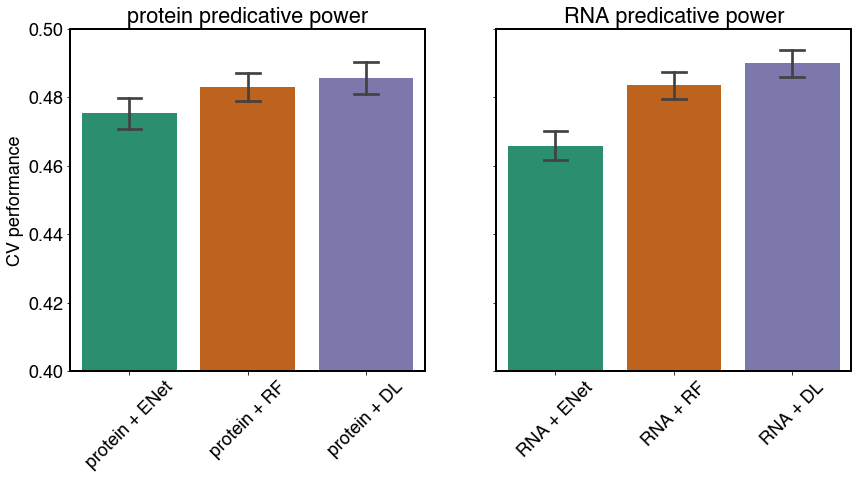

In [137]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
sns.barplot(x='key', y='val_score', data=protein_cv_bar, capsize=.2, ax=ax[0])
sns.barplot(x='key', y='val_score', data=rna_cv_bar, capsize=.2, ax=ax[1])
ax[0].set_ylabel('CV performance')
ax[0].set_xlabel('')
ax[0].set_title('protein predicative power')
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_title('RNA predicative power')
plt.ylim(0.4,0.5)
fig.autofmt_xdate(rotation=45, ha='center')

In [138]:
en_cv_bar = pd.concat([scores_en_protein_cv_long, scores_en_rna_cv_long])
rf_cv_bar = pd.concat([scores_rf_protein_cv_long, scores_rf_rna_cv_long])
dl_cv_bar = pd.concat([scores_dl_protein_cv_long, scores_dl_rna_cv_long])
en_cv_bar['key'] = en_cv_bar.apply(lambda row:f"{row['data']} + {row['model']}", axis=1)
rf_cv_bar['key'] = rf_cv_bar.apply(lambda row:f"{row['data']} + {row['model']}", axis=1)
dl_cv_bar['key'] = dl_cv_bar.apply(lambda row:f"{row['data']} + {row['model']}", axis=1)

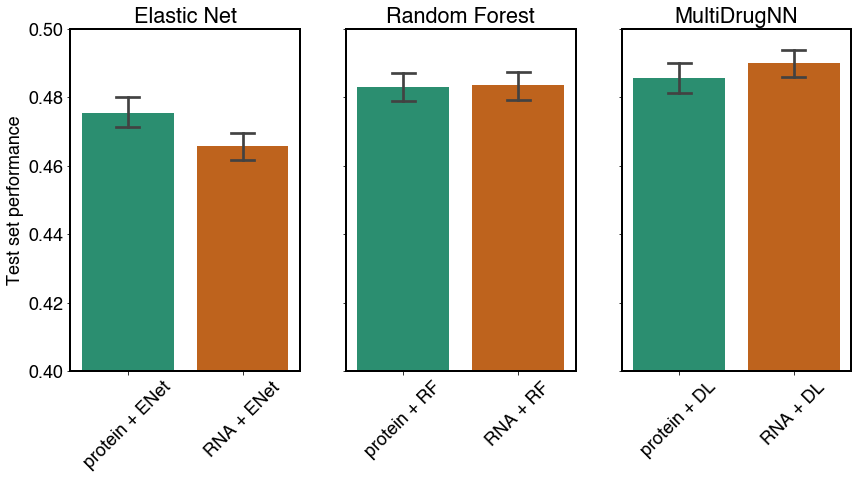

In [139]:
fig, ax = plt.subplots(1, 3, figsize=(14, 7), sharey=True)
sns.barplot(x='key', y='val_score', data=en_cv_bar, capsize=.2, ax=ax[0])
sns.barplot(x='key', y='val_score', data=rf_cv_bar, capsize=.2, ax=ax[1])
sns.barplot(x='key', y='val_score', data=dl_cv_bar, capsize=.2, ax=ax[2])

ax[0].set_ylabel('Test set performance')
ax[0].set_xlabel('')
ax[0].set_title('Elastic Net')
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_title('Random Forest')
ax[2].set_ylabel('')
ax[2].set_xlabel('')
ax[2].set_title('MultiDrugNN')
plt.ylim(0.4,0.5)
fig.autofmt_xdate(rotation=45, ha='center')

### stability

In [140]:
scores_en_rna_cv_long_stderr = scores_en_rna_cv_long.groupby(
    ['drug_id', 'model',
     'data'])['val_score'].std().reset_index(name='std_erorr')
scores_rf_rna_cv_long_stderr = scores_rf_rna_cv_long.groupby(
    ['drug_id', 'model',
     'data'])['val_score'].std().reset_index(name='std_erorr')
scores_dl_rna_cv_long_stderr = scores_dl_rna_cv_long.groupby(
    ['drug_id', 'model',
     'data'])['val_score'].std().reset_index(name='std_erorr')

In [141]:
scores_en_protein_cv_long_stderr = scores_en_protein_cv_long.groupby(
    ['drug_id', 'model',
     'data'])['val_score'].std().reset_index(name='std_erorr')
scores_rf_protein_cv_long_stderr = scores_rf_protein_cv_long.groupby(
    ['drug_id', 'model',
     'data'])['val_score'].std().reset_index(name='std_erorr')
scores_dl_protein_cv_long_stderr = scores_dl_protein_cv_long.groupby(
    ['drug_id', 'model',
     'data'])['val_score'].std().reset_index(name='std_erorr')

In [142]:
rna_cv_bar_stderr = pd.concat([
    scores_en_rna_cv_long_stderr, scores_rf_rna_cv_long_stderr,
    scores_dl_rna_cv_long_stderr
])
rna_cv_bar_stderr['key'] = rna_cv_bar_stderr.apply(
    lambda row: f"{row['data']} + {row['model']}", axis=1)

protein_cv_bar_stderr = pd.concat([
    scores_en_protein_cv_long_stderr, scores_rf_protein_cv_long_stderr,
    scores_dl_protein_cv_long_stderr
])
protein_cv_bar_stderr['key'] = protein_cv_bar_stderr.apply(
    lambda row: f"{row['data']} + {row['model']}", axis=1)

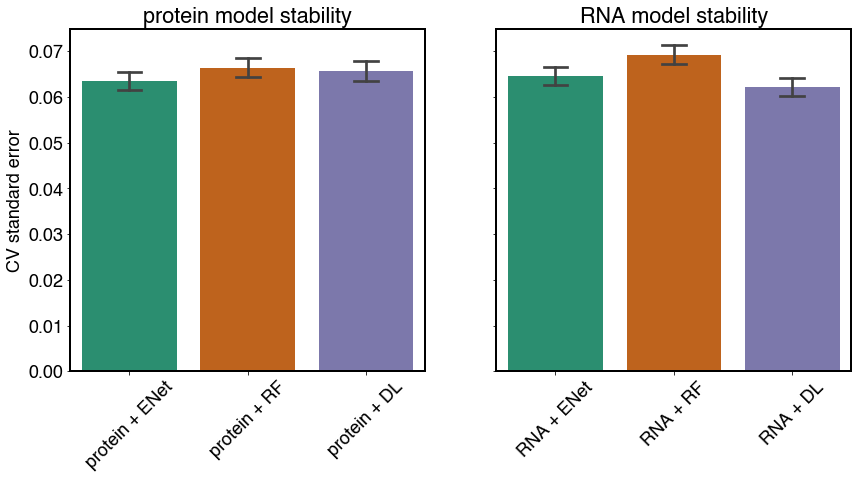

In [143]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
sns.barplot(x='key', y='std_erorr', data=protein_cv_bar_stderr, capsize=.2, ax=ax[0])
sns.barplot(x='key', y='std_erorr', data=rna_cv_bar_stderr, capsize=.2, ax=ax[1])
ax[0].set_ylabel('CV standard error')
ax[0].set_xlabel('')
ax[0].set_title('protein model stability')
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_title('RNA model stability')
fig.autofmt_xdate(rotation=45, ha='center')
# plt.savefig("../plots/drug/Fig4S-D.pdf")

## CV + Test consistency

### ENet

In [144]:
combined_en = pd.concat([
    test_corr_df_en.rename(columns={'test_corr': 'score'}),
    scores_en_protein_cv_long.rename(columns={'val_score': 'score'}),
    scores_en_rna_cv_long.rename(columns={'val_score': 'score'})
])
combined_corr_df_en_scatter = pd.pivot(combined_en.groupby(
    ['drug_id', 'data'])['score'].mean().reset_index(name='score'),
                                       index='drug_id',
                                       columns='data', values='score')

In [145]:
combined_corr_df_en_scatter['delta'] = combined_corr_df_en_scatter[
    'protein'] - combined_corr_df_en_scatter['RNA']
combined_corr_df_en_scatter.sort_values(by='delta', ascending=False).head(20)

data,RNA,protein,delta
drug_id,,,
2255;RK-33;GDSC2,0.231102,0.427675,0.196572
1960;SYK_9721;GDSC2,0.408529,0.597210,0.188681
2309;AC220;GDSC2,0.452996,0.585433,0.132438
1239;YK-4-279;GDSC1,0.355412,0.480966,0.125554
1378;Bleomycin (50 uM);GDSC2,0.362795,0.481611,0.118816
381;AST-1306;GDSC1,0.231064,0.349191,0.118127
2074;EGFR_0300;GDSC2,0.335262,0.451259,0.115997
2312;PDD00017273;GDSC2,0.456443,0.572340,0.115896
2295;NVS-PAK1-1;GDSC2,0.275562,0.389154,0.113592


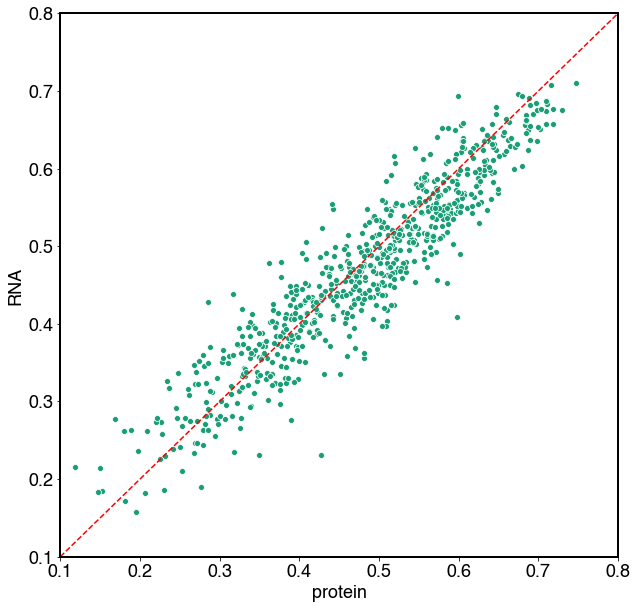

In [146]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x='protein', y='RNA', data=combined_corr_df_en_scatter)
plt.xlim(0.1,0.8)
plt.ylim(0.1,0.8)
plt.plot((0.1,0.8), (0.1,0.8), ls="--", c='red')
# ax.annotate('Motesanib:RTK signaling',
#             xy=(0.547190, 0.175817), xycoords='data',
#             xytext=(-30, 40), textcoords='offset points',
#             arrowprops=dict(arrowstyle="->"), fontsize=16)

### RF

In [147]:
combined_rf = pd.concat([
    test_corr_df_rf.rename(columns={'test_corr': 'score'}),
    scores_rf_protein_cv_long.rename(columns={'val_score': 'score'}),
    scores_rf_rna_cv_long.rename(columns={'val_score': 'score'})
])
combined_corr_df_rf_scatter = pd.pivot(combined_rf.groupby(
    ['drug_id', 'data'])['score'].mean().reset_index(name='score'),
                                       index='drug_id',
                                       columns='data', values='score')

In [148]:
combined_corr_df_rf_scatter['delta'] = combined_corr_df_rf_scatter[
    'protein'] - combined_corr_df_rf_scatter['RNA']
combined_corr_df_rf_scatter.sort_values(by='delta', ascending=False).head()

data,RNA,protein,delta
drug_id,,,
2255;RK-33;GDSC2,0.284601,0.449770,0.165169
1239;YK-4-279;GDSC1,0.415228,0.499383,0.084155
1149;TW 37;GDSC2,0.441177,0.521875,0.080698
63;BMS-509744;GDSC1,0.234320,0.311827,0.077507
1451;PLK_6522;GDSC1,0.454152,0.531567,0.077415


Text(-30, 40, 'Motesanib:RTK signaling')

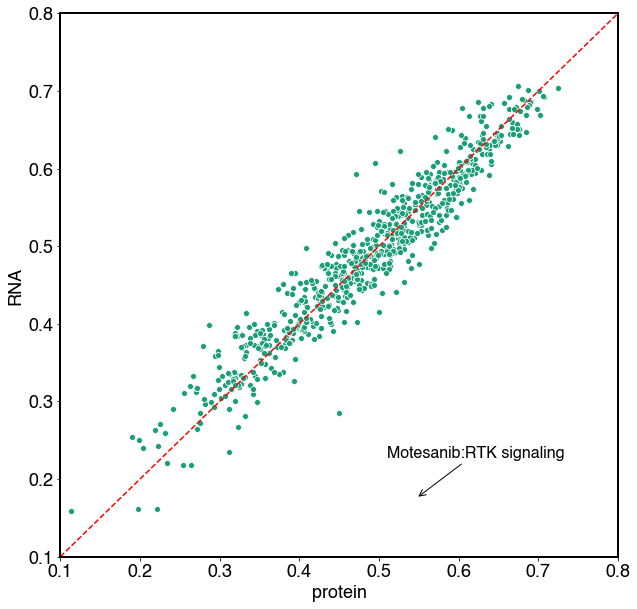

In [149]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x='protein', y='RNA', data=combined_corr_df_rf_scatter)
plt.xlim(0.1,0.8)
plt.ylim(0.1,0.8)
plt.plot((0.1,0.8), (0.1,0.8), ls="--", c='red')
ax.annotate('Motesanib:RTK signaling',
            xy=(0.547190, 0.175817), xycoords='data',
            xytext=(-30, 40), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"), fontsize=16)

In [150]:
pearsonr(combined_corr_df_rf_scatter['RNA'],
         combined_corr_df_rf_scatter['protein'])

(0.9589836722538427, 0.0)

### DL

In [151]:
combined_dl = pd.concat([
    test_corr_df_dl.rename(columns={'test_corr': 'score'}),
    scores_dl_protein_cv_long.rename(columns={'val_score': 'score'}),
    scores_dl_rna_cv_long.rename(columns={'val_score': 'score'})
])
combined_corr_df_dl_scatter = pd.pivot(combined_dl.groupby(
    ['drug_id', 'data'])['score'].mean().reset_index(name='score'),
                                       index='drug_id',
                                       columns='data', values='score')

In [152]:
combined_corr_df_dl_scatter['delta'] = combined_corr_df_dl_scatter[
    'protein'] - combined_corr_df_dl_scatter['RNA']
combined_corr_df_dl_scatter.sort_values(by='delta', ascending=False).head()

data,RNA,protein,delta
drug_id,,,
1008;Methotrexate;GDSC2,0.464863,0.579664,0.114801
2255;RK-33;GDSC2,0.329462,0.429618,0.100156
1960;SYK_9721;GDSC2,0.470136,0.566258,0.096123
1936;Savolitinib;GDSC2,0.437561,0.528422,0.090861
2321;Salvinorin A;GDSC2,0.396196,0.485003,0.088808


In [153]:
combined_corr_df_dl_scatter.sort_values(by='delta', ascending=False).head(10)

data,RNA,protein,delta
drug_id,,,
1008;Methotrexate;GDSC2,0.464863,0.579664,0.114801
2255;RK-33;GDSC2,0.329462,0.429618,0.100156
1960;SYK_9721;GDSC2,0.470136,0.566258,0.096123
1936;Savolitinib;GDSC2,0.437561,0.528422,0.090861
2321;Salvinorin A;GDSC2,0.396196,0.485003,0.088808
2284;MS023;GDSC2,0.519085,0.590094,0.071009
1049;PD173074;GDSC2,0.432966,0.501986,0.069020
71;Pyrimethamine;GDSC1,0.352966,0.419286,0.066321
1990;BCL6_7224;GDSC2,0.567001,0.631545,0.064544


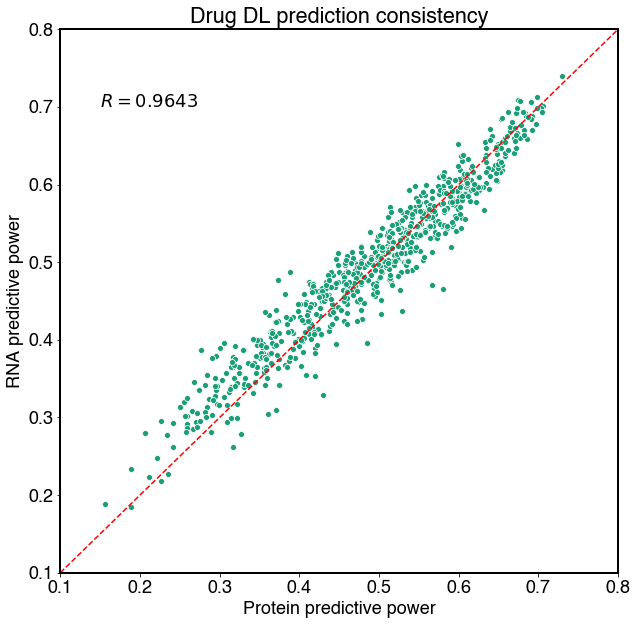

In [154]:
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x='protein', y='RNA', data=combined_corr_df_dl_scatter)
plt.xlim(0.1, 0.8)
plt.ylim(0.1, 0.8)
plt.plot((0.1, 0.8), (0.1, 0.8), ls="--", c='red')

plt.title("Drug DL prediction consistency")
plt.ylabel("RNA predictive power")
plt.xlabel("Protein predictive power")
# ax.annotate(f'1008;Methotrexate;GDSC2',
#             xy=(0.579664, 0.464863),
#             xycoords='data',
#             xytext=(-30, -40),
#             textcoords='offset points',
#             arrowprops=dict(arrowstyle="->"),
#             fontsize=16)
# ax.annotate(f'2359;GSK2830371;GDSC2',
#             xy=(0.729555, 0.739527),
#             xycoords='data',
#             xytext=(-280, -40),
#             textcoords='offset points',
#             arrowprops=dict(arrowstyle="->"),
#             fontsize=16)
plt.text(
    0.15, 0.7,
    f"$R={pearsonr(combined_corr_df_dl_scatter['RNA'], combined_corr_df_dl_scatter['protein'])[0]:.4f}$"
)
plt.savefig("../plots/drug/Fig4A_scatter_rna_protein_drug_no_name.pdf", dpi=500)

In [91]:
combined_corr_df_dl_scatter.to_csv("../plots/plot_data/Fig4A_scatter_rna_protein_drug.csv")

In [92]:
pearsonr(combined_corr_df_dl_scatter['RNA'],
         combined_corr_df_dl_scatter['protein'])

(0.9643041529721152, 0.0)

#### t-test

In [155]:
dl_ttest_df = []
for drug_id in combined_dl['drug_id'].unique():
    target = combined_dl[combined_dl['drug_id'] == drug_id]
    target_protein = target[target['data'] == 'protein']
    target_rna = target[target['data'] == 'RNA']
    dl_ttest_df.append({
        'drug_id':
        drug_id,
        'RNA_predictive_power':
        target_rna['score'].mean(),
        'protein_predictive_power':
        target_protein['score'].mean(),
        'pvalue':
        ttest_rel(target_protein['score'], target_rna['score'])[1]
    })
dl_ttest_df = pd.DataFrame(dl_ttest_df)
dl_ttest_df['protein_improvement'] = dl_ttest_df[
    'protein_predictive_power'] - dl_ttest_df['RNA_predictive_power']
dl_ttest_df['-log(pval)'] = -np.log10(dl_ttest_df['pvalue'])
dl_ttest_df['target_pathway'] = dl_ttest_df['drug_id'].map(target_pathway_map)

In [156]:
dl_ttest_df['FDR'] = multipletests(dl_ttest_df['pvalue'], method='fdr_bh', alpha=0.1)[1]
dl_ttest_df['-log(FDR)'] = -np.log10(dl_ttest_df['FDR'])

In [157]:
dl_ttest_df[(dl_ttest_df['FDR'] < 0.05)
            & (dl_ttest_df['protein_improvement'] > 0.05)].sort_values(
                by=['protein_improvement'], ascending=False)

,drug_id,RNA_predictive_power,protein_predictive_power,pvalue,protein_improvement,-log(pval),target_pathway,FDR,-log(FDR)


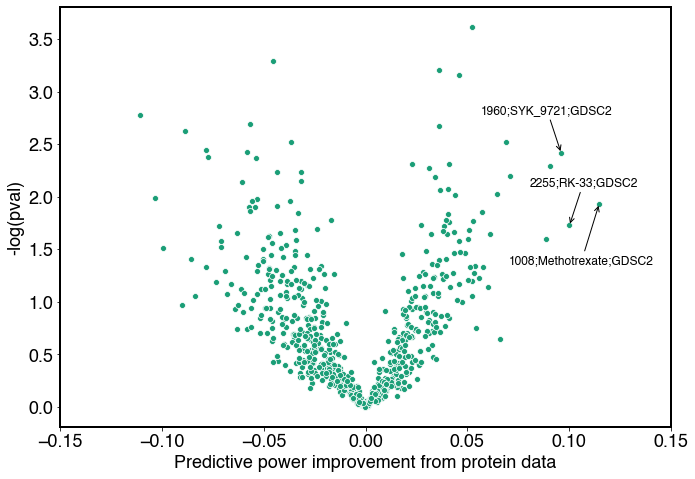

In [158]:
ax = sns.scatterplot(x='protein_improvement', y='-log(pval)', data=dl_ttest_df)

ax.annotate(f'1008;Methotrexate;GDSC2',
            xy=(0.114801, 1.934170),
            xycoords='data',
            xytext=(-90, -60),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->"),
            fontsize=12)
ax.annotate(f'1960;SYK_9721;GDSC2',
            xy=(0.096123, 2.416470),
            xycoords='data',
            xytext=(-80, 40),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->"),
            fontsize=12)
ax.annotate(f'2255;RK-33;GDSC2',
            xy=(0.100156, 1.727392),
            xycoords='data',
            xytext=(-40, 40),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->"),
            fontsize=12)
plt.xlabel("Predictive power improvement from protein data")
plt.xlim(-0.15,0.15)
plt.tight_layout()
plt.savefig("../plots/drug/protein_rna_volcano.pdf", dpi=500)

In [97]:
dl_ttest_df.to_csv("../data/drug/dl_ttest_df.csv", index=False)

#### count plot

In [159]:
dl_ttest_df['cagetory'] = dl_ttest_df['protein_improvement'].map(
    lambda x: 'RNA better' if x < 0 else 'Protein better')

In [160]:
df_count = dl_ttest_df.groupby(['target_pathway', 'cagetory']).size().reset_index(name='count')
df_count.to_csv("../plots/plot_data/SuppFig8E_protein_vs_RNA_counts.csv", index=False)

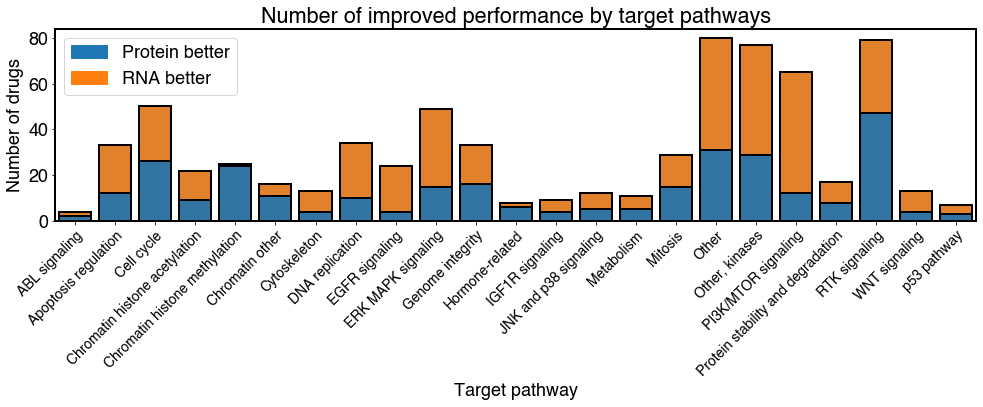

In [163]:
plt.figure(figsize=(14,6))
g1 = sns.countplot(x='target_pathway',
                   data=dl_ttest_df,
                   order=sorted(dl_ttest_df['target_pathway'].unique()),
                   linewidth=2,
                   edgecolor='black',
                   color='#ff7f0e')
g2 = sns.countplot(x='target_pathway',
                   data=dl_ttest_df[dl_ttest_df['protein_improvement'] > 0],
                   order=sorted(dl_ttest_df['target_pathway'].unique()),
                   linewidth=2,
                   edgecolor='black',
                   color="#1f77b4")

total_patch = mpatches.Patch(color='#ff7f0e', label='RNA better')
improved_patch = mpatches.Patch(color='#1f77b4', label='Protein better')

plt.legend(handles=[total_patch, improved_patch])

plt.legend(handles=[improved_patch, total_patch])
plt.ylabel('Number of drugs')
plt.xlabel('Target pathway')
plt.xticks(rotation=45, ha='right', size=14, rotation_mode="anchor")
plt.title("Number of improved performance by target pathways")
plt.tight_layout()
# plt.savefig("../plots/drug/rna_protein_diff_count.pdf", dpi=500)

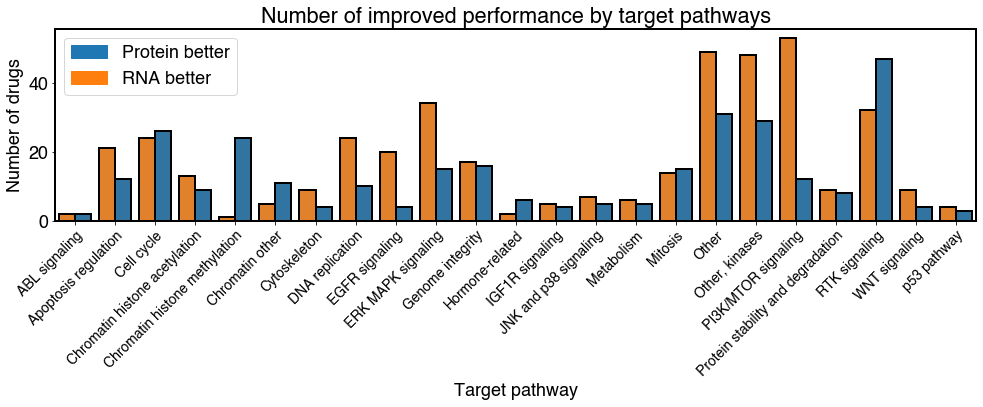

In [174]:
plt.figure(figsize=(14, 6))
g1 = sns.countplot(x='target_pathway',
                   data=dl_ttest_df,
                   hue='cagetory',
                   order=sorted(dl_ttest_df['target_pathway'].unique()),
                   linewidth=2,
                   edgecolor='black',
                   palette=['#ff7f0e', "#1f77b4"])

plt.legend(handles=[total_patch, improved_patch])

plt.legend(handles=[improved_patch, total_patch])
plt.ylabel('Number of drugs')
plt.xlabel('Target pathway')
plt.xticks(rotation=45, ha='right', size=14, rotation_mode="anchor")
plt.title("Number of improved performance by target pathways")
plt.tight_layout()
plt.savefig("../plots/drug/rna_protein_diff_count.pdf", dpi=500)

# growth rate

In [44]:
col = ['drug_id', 'test_corr']

## data comparison

### load data

In [40]:
scores_multi_rna = pd.read_csv(
    "../work_dirs/rna/MultiDrug/scores_202006181624_res_eg_id.csv")
scores_multi_rna = scores_multi_rna[
    scores_multi_rna['run'] == 'test'].reset_index(drop=True).rename(
        columns={'corr': 'test_corr'})

scores_multi_rna_growth_corrected = pd.read_csv(
    "../work_dirs/rna/MultiDrug/scores_202006181625_res_growth_corrected_eg_id.csv"
)
scores_multi_rna_growth_corrected = scores_multi_rna_growth_corrected[
    scores_multi_rna_growth_corrected['run'] == 'test'].reset_index(
        drop=True).rename(columns={'corr': 'test_corr'})

scores_multi_rna_pc1_corrected = pd.read_csv(
    "../work_dirs/rna/MultiDrug/scores_202006182112_res_pc1_corrected_eg_id.csv"
)
scores_multi_rna_pc1_corrected = scores_multi_rna_pc1_corrected[
    scores_multi_rna_pc1_corrected['run'] == 'test'].reset_index(
        drop=True).rename(columns={'corr': 'test_corr'})

In [41]:
scores_multi_protein = pd.read_csv(
    "../work_dirs/protein/MultiDrug/scores_202006191021_resx_ruv_zero_300_eg_id.csv")
scores_multi_protein = scores_multi_protein[
    scores_multi_protein['run'] == 'test'].reset_index(drop=True).rename(
        columns={'corr': 'test_corr'})

scores_multi_protein_growth_corrected = pd.read_csv(
    "../work_dirs/protein/MultiDrug/scores_202006181433_resx_ruv_zero_300_growth_corrected_eg_id.csv"
)
scores_multi_protein_growth_corrected = scores_multi_protein_growth_corrected[
    scores_multi_protein_growth_corrected['run'] == 'test'].reset_index(
        drop=True).rename(columns={'corr': 'test_corr'})

scores_multi_protein_pc1_corrected = pd.read_csv(
    "../work_dirs/protein/MultiDrug/scores_202006181433_resx_ruv_zero_300_pc1_corrected_eg_id.csv"
)
scores_multi_protein_pc1_corrected = scores_multi_protein_pc1_corrected[
    scores_multi_protein_pc1_corrected['run'] == 'test'].reset_index(
        drop=True).rename(columns={'corr': 'test_corr'})

In [45]:
rna_df = scores_multi_rna[scores_multi_rna['epoch'] ==
                                  240][col].reset_index(drop=True)
rna_df['model'] = 'DL'
rna_df['data'] = 'RNA + IC50'

rna_df_growth_corrected = scores_multi_rna_growth_corrected[
    scores_multi_rna_growth_corrected['epoch'] == 130][col].reset_index(
        drop=True)
rna_df_growth_corrected['model'] = 'DL'
rna_df_growth_corrected['data'] = 'RNA + IC50(no GR)'

rna_df_pc1_corrected = scores_multi_rna_pc1_corrected[
    scores_multi_rna_pc1_corrected['epoch'] == 70][col].reset_index(
        drop=True)
rna_df_pc1_corrected['model'] = 'DL'
rna_df_pc1_corrected['data'] = 'RNA + IC50(no PC1)'

test_corr_df_rna = pd.concat(
    [rna_df, rna_df_growth_corrected, rna_df_pc1_corrected])

test_corr_df_rna['key'] = test_corr_df_rna.apply(
    lambda row: f"{row['data']}", axis=1)

In [46]:
protein_df = scores_multi_protein[scores_multi_protein['epoch'] ==
                                  70][col].reset_index(drop=True)
protein_df['model'] = 'DL'
protein_df['data'] = 'protein + IC50'

protein_df_growth_corrected = scores_multi_protein_growth_corrected[
    scores_multi_protein_growth_corrected['epoch'] == 25][col].reset_index(
        drop=True)
protein_df_growth_corrected['model'] = 'DL'
protein_df_growth_corrected['data'] = 'protein + IC50(no GR)'

protein_df_pc1_corrected = scores_multi_protein_pc1_corrected[
    scores_multi_protein_pc1_corrected['epoch'] == 25][col].reset_index(
        drop=True)
protein_df_pc1_corrected['model'] = 'DL'
protein_df_pc1_corrected['data'] = 'protein + IC50(no PC1)'

test_corr_df_protein = pd.concat(
    [protein_df, protein_df_growth_corrected, protein_df_pc1_corrected])

test_corr_df_protein['key'] = test_corr_df_protein.apply(
    lambda row: f"{row['data']}", axis=1)

### plot

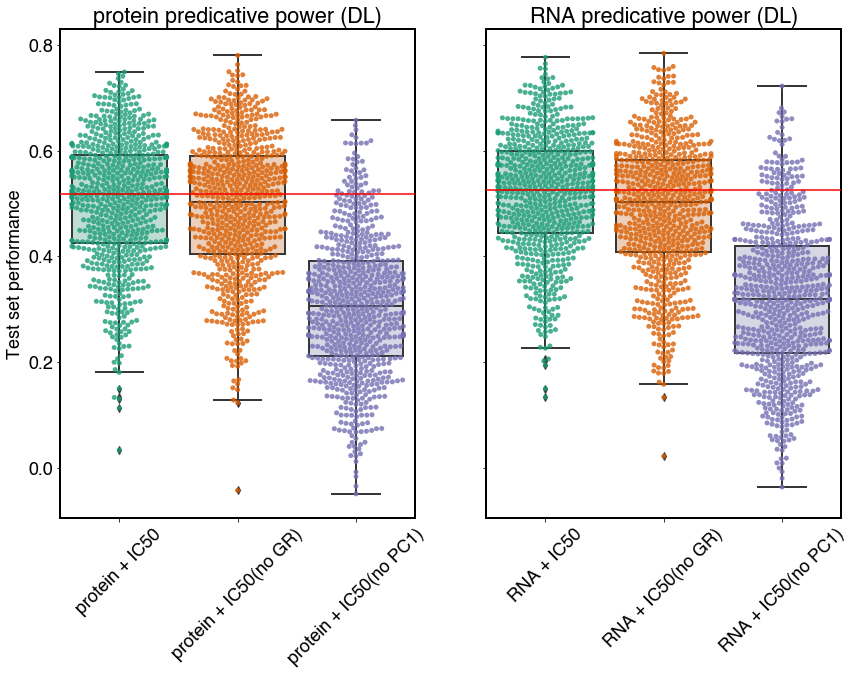

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(14, 10), sharey=True)
ga = sns.boxplot('key',
            'test_corr',
            data=test_corr_df_protein,
            orient='v',
            linewidth=2,
            ax=ax[0])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.swarmplot('key',
              'test_corr',
              data=test_corr_df_protein,
              orient='vh',
              alpha=.8,
              ax=ax[0])

x1, x2 = 1, 2  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y = test_corr_df_protein[
    test_corr_df_protein['key'] ==
    'protein + IC50']['test_corr'].median()
ax[0].plot((-0.5,2.5), [y, y], color='red', zorder=10)


ga = sns.boxplot('key',
            'test_corr',
            data=test_corr_df_rna,
            orient='v',
            linewidth=2,
            ax=ax[1])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.swarmplot('key',
              'test_corr',
              data=test_corr_df_rna,
              orient='vh',
              alpha=.8,
              ax=ax[1])


y = test_corr_df_rna[
    test_corr_df_rna['key'] ==
    'RNA + IC50']['test_corr'].median()
ax[1].plot((-0.5,2.5), [y, y], color='red', zorder=10)


ax[0].set_ylabel('Test set performance')
ax[0].set_xlabel('')
ax[0].set_title('protein predicative power (DL)')
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_title('RNA predicative power (DL)')
# plt.ylim(0, .9)
fig.autofmt_xdate(rotation=45, ha='center')

## model comparison

### load RF

In [93]:
scores_rf_rna = pd.read_csv(
    "../work_dirs/rna/RandomForest/scores_202006051532_rna_300.csv")[col]
scores_rf_rna['model'] = 'RF'
scores_rf_rna['data'] = 'RNA + IC50'

scores_rf_rna_growth_corrected = pd.read_csv(
    "../work_dirs/rna/RandomForest/scores_202006062032_rna_300_growth_corrected.csv")[col]
scores_rf_rna_growth_corrected['model'] = 'RF'
scores_rf_rna_growth_corrected['data'] = 'RNA + IC50(no GR)'

scores_rf_rna_pc1_corrected = pd.read_csv(
    "../work_dirs/rna/RandomForest/scores_202006062032_rna_300_pc1_corrected.csv")[col]
scores_rf_rna_pc1_corrected['model'] = 'RF'
scores_rf_rna_pc1_corrected['data'] = 'RNA + IC50(no PC1)'

In [94]:
scores_rf_protein = pd.read_csv(
    "../work_dirs/protein/RandomForest/scores_202006051013_ruv_min_300.csv")[col]
scores_rf_protein['model'] = 'RF'
scores_rf_protein['data'] = 'protein + IC50'

scores_rf_protein_growth_corrected = pd.read_csv(
    "../work_dirs/protein/RandomForest/scores_202006052029_ruv_min_300_growth_corrected.csv")[col]
scores_rf_protein_growth_corrected['model'] = 'RF'
scores_rf_protein_growth_corrected['data'] = 'protein + IC50(no GR)'

scores_rf_protein_pc1_corrected = pd.read_csv(
    "../work_dirs/protein/RandomForest/scores_202006061137_ruv_min_300_pc1_corrected.csv")[col]
scores_rf_protein_pc1_corrected['model'] = 'RF'
scores_rf_protein_pc1_corrected['data'] = 'protein + IC50(no PC1)'

In [95]:
scores_dl_rna = scores_multi_rna[scores_multi_rna['epoch'] ==
                                  210][col].reset_index(drop=True)
scores_dl_rna['model'] = 'DL'
scores_dl_rna['data'] = 'RNA + IC50'

scores_dl_rna_growth_corrected = scores_multi_rna_growth_corrected[
    scores_multi_rna_growth_corrected['epoch'] == 130][col].reset_index(
        drop=True)
scores_dl_rna_growth_corrected['model'] = 'DL'
scores_dl_rna_growth_corrected['data'] = 'RNA + IC50(no GR)'

scores_dl_rna_pc1_corrected = scores_multi_rna_pc1_corrected[
    scores_multi_rna_pc1_corrected['epoch'] == 70][col].reset_index(
        drop=True)
scores_dl_rna_pc1_corrected['model'] = 'DL'
scores_dl_rna_pc1_corrected['data'] = 'RNA + IC50(no PC1)'

In [97]:
scores_dl_protein = scores_multi_protein[scores_multi_protein['epoch'] ==
                                  70][col].reset_index(drop=True)
scores_dl_protein['model'] = 'DL'
scores_dl_protein['data'] = 'protein + IC50'

scores_dl_protein_growth_corrected = scores_multi_protein_growth_corrected[
    scores_multi_protein_growth_corrected['epoch'] == 25][col].reset_index(
        drop=True)
scores_dl_protein_growth_corrected['model'] = 'DL'
scores_dl_protein_growth_corrected['data'] = 'protein + IC50(no GR)'

scores_dl_protein_pc1_corrected = scores_multi_protein_pc1_corrected[
    scores_multi_protein_pc1_corrected['epoch'] == 25][col].reset_index(
        drop=True)
scores_dl_protein_pc1_corrected['model'] = 'DL'
scores_dl_protein_pc1_corrected['data'] = 'protein + IC50(no PC1)'

In [100]:
test_corr_rna_ori = pd.concat([scores_rf_rna, scores_dl_rna])
test_corr_rna_ori['key'] = test_corr_rna_ori.apply(
    lambda row: f"{row['data']} + {row['model']}", axis=1)

test_corr_rna_growth_corrected = pd.concat([scores_rf_rna_growth_corrected, scores_dl_rna_growth_corrected])
test_corr_rna_growth_corrected['key'] = test_corr_rna_growth_corrected.apply(
    lambda row: f"{row['data']} + {row['model']}", axis=1)

test_corr_rna_pc1_corrected = pd.concat([scores_rf_rna_pc1_corrected, scores_dl_rna_pc1_corrected])
test_corr_rna_pc1_corrected['key'] = test_corr_rna_pc1_corrected.apply(
    lambda row: f"{row['data']} + {row['model']}", axis=1)

In [111]:
test_corr_protein_ori = pd.concat([scores_rf_protein, scores_dl_protein])
test_corr_protein_ori['key'] = test_corr_protein_ori.apply(
    lambda row: f"{row['data']} + {row['model']}", axis=1)

test_corr_protein_growth_corrected = pd.concat([scores_rf_protein_growth_corrected, scores_dl_protein_growth_corrected])
test_corr_protein_growth_corrected['key'] = test_corr_protein_growth_corrected.apply(
    lambda row: f"{row['data']} + {row['model']}", axis=1)

test_corr_protein_pc1_corrected = pd.concat([scores_rf_protein_pc1_corrected, scores_dl_protein_pc1_corrected])
test_corr_protein_pc1_corrected['key'] = test_corr_protein_pc1_corrected.apply(
    lambda row: f"{row['data']} + {row['model']}", axis=1)

### plot

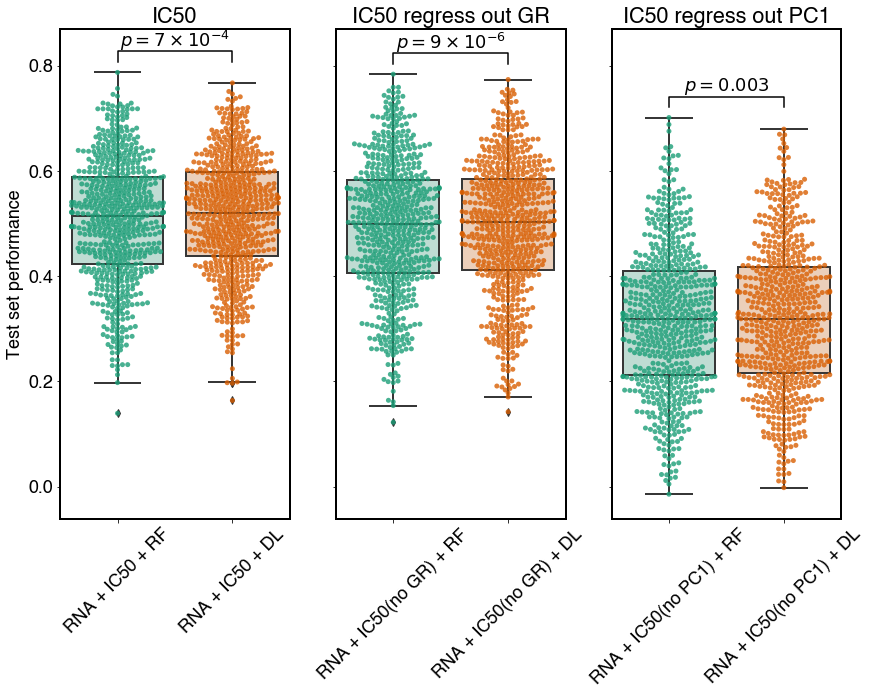

In [104]:
fig, ax = plt.subplots(1, 3, figsize=(14, 10), sharey=True)
ga = sns.boxplot('key',
            'test_corr',
            data=test_corr_rna_ori,
            orient='v',
            linewidth=2,
            ax=ax[0])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.swarmplot('key',
              'test_corr',
              data=test_corr_rna_ori,
              orient='vh',
              alpha=.8,
              ax=ax[0])

x1, x2 = 0, 1  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = test_corr_rna_ori['test_corr'].max() + 0.02, 0.02, 'k'
ax[0].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[0].text((x1 + x2) * .5,
           y + w + 0.02,
           r"$p=5\times10^{-6}$",
           ha='center',
           va='center',
           color=col)

ga = sns.boxplot('key',
            'test_corr',
            data=test_corr_rna_growth_corrected,
            orient='v',
            linewidth=2,
            ax=ax[1])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.swarmplot('key',
              'test_corr',
              data=test_corr_rna_growth_corrected,
              orient='vh',
              alpha=.8,
              ax=ax[1])

x1, x2 = 0, 1  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = test_corr_rna_growth_corrected['test_corr'].max() + 0.02, 0.02, 'k'
ax[1].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[1].text((x1 + x2) * .5,
           y + w + 0.02,
           r"$p=9\times10^{-6}$",
           ha='center',
           va='center',
           color=col)
# y = test_corr_df_rf[
#     test_corr_df_rf['key'] ==
#     'protein + DL']['test_corr'].median()
# ax[1].plot((-0.5,2.5), [y, y], color='red', zorder=10)

ga = sns.boxplot('key',
            'test_corr',
            data=test_corr_rna_pc1_corrected,
            orient='v',
            linewidth=2,
            ax=ax[2])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.swarmplot('key',
              'test_corr',
              data=test_corr_rna_pc1_corrected,
              orient='vh',
              alpha=.8,
              ax=ax[2])

x1, x2 = 0, 1  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = test_corr_rna_pc1_corrected['test_corr'].max() + 0.02, 0.02, 'k'
ax[2].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[2].text((x1 + x2) * .5,
           y + w + 0.02,
           r"$p=0.003$",
           ha='center',
           va='center',
           color=col)

ax[0].set_ylabel('Test set performance')
ax[0].set_xlabel('')
ax[0].set_title('IC50')
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_title('IC50 regress out GR')
ax[2].set_ylabel('')
ax[2].set_xlabel('')
ax[2].set_title('IC50 regress out PC1')
fig.autofmt_xdate(rotation=45, ha='center')

In [113]:
print(ttest_rel(test_corr_rna_ori[test_corr_rna_ori['key']=='RNA + IC50 + RF']['test_corr'].values,
          test_corr_rna_ori[test_corr_rna_ori['key']=='RNA + IC50 + DL']['test_corr'].values))

print(ttest_rel(
    test_corr_rna_growth_corrected[test_corr_rna_growth_corrected['key'] ==
                                   'RNA + IC50(no GR) + RF']['test_corr'].values,
    test_corr_rna_growth_corrected[test_corr_rna_growth_corrected['key'] ==
                                   'RNA + IC50(no GR) + DL']['test_corr'].values))

print(ttest_rel(
    test_corr_rna_pc1_corrected[test_corr_rna_pc1_corrected['key'] ==
                                'RNA + IC50(no PC1) + RF']['test_corr'].values,
    test_corr_rna_pc1_corrected[test_corr_rna_pc1_corrected['key'] ==
                                'RNA + IC50(no PC1) + DL']['test_corr'].values))

Ttest_relResult(statistic=-4.603014660235213, pvalue=5.009224539650335e-06)
Ttest_relResult(statistic=-0.15901289372095997, pvalue=0.8737081086516396)
Ttest_relResult(statistic=-1.6445874878669922, pvalue=0.10053841105061011)


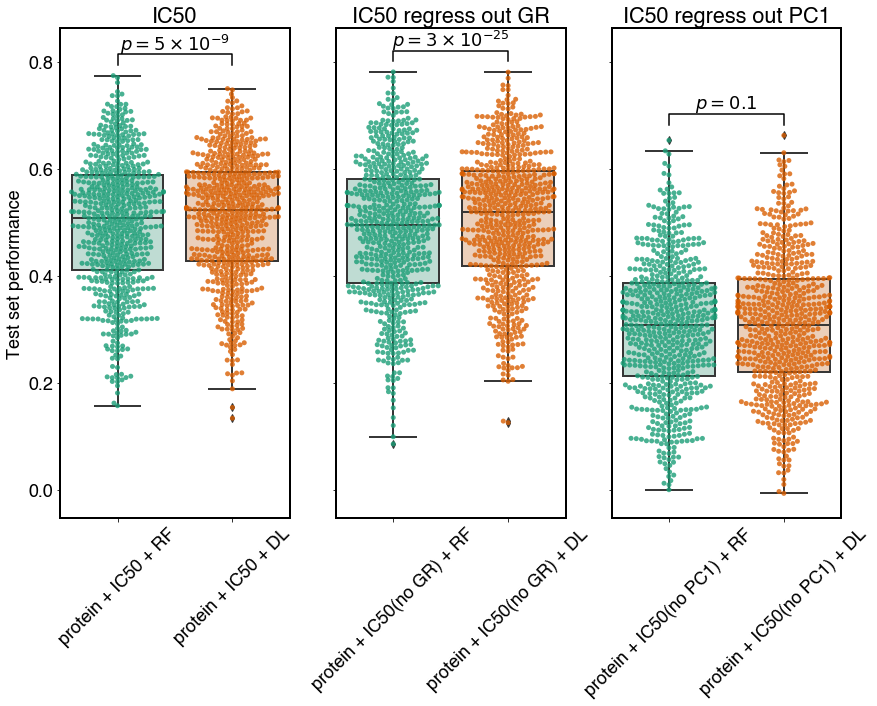

In [115]:
fig, ax = plt.subplots(1, 3, figsize=(14, 10), sharey=True)
ga = sns.boxplot('key',
            'test_corr',
            data=test_corr_protein_ori,
            orient='v',
            linewidth=2,
            ax=ax[0])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.swarmplot('key',
              'test_corr',
              data=test_corr_protein_ori,
              orient='vh',
              alpha=.8,
              ax=ax[0])

x1, x2 = 0, 1  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = test_corr_protein_ori['test_corr'].max() + 0.02, 0.02, 'k'
ax[0].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[0].text((x1 + x2) * .5,
           y + w + 0.02,
           r"$p=5\times10^{-9}$",
           ha='center',
           va='center',
           color=col)

ga = sns.boxplot('key',
            'test_corr',
            data=test_corr_protein_growth_corrected,
            orient='v',
            linewidth=2,
            ax=ax[1])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.swarmplot('key',
              'test_corr',
              data=test_corr_protein_growth_corrected,
              orient='vh',
              alpha=.8,
              ax=ax[1])

x1, x2 = 0, 1  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = test_corr_protein_growth_corrected['test_corr'].max() + 0.02, 0.02, 'k'
ax[1].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[1].text((x1 + x2) * .5,
           y + w + 0.02,
           r"$p=3\times10^{-25}$",
           ha='center',
           va='center',
           color=col)
# y = test_corr_df_rf[
#     test_corr_df_rf['key'] ==
#     'protein + DL']['test_corr'].median()
# ax[1].plot((-0.5,2.5), [y, y], color='red', zorder=10)

ga = sns.boxplot('key',
            'test_corr',
            data=test_corr_protein_pc1_corrected,
            orient='v',
            linewidth=2,
            ax=ax[2])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.swarmplot('key',
              'test_corr',
              data=test_corr_protein_pc1_corrected,
              orient='vh',
              alpha=.8,
              ax=ax[2])

x1, x2 = 0, 1  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = test_corr_protein_pc1_corrected['test_corr'].max() + 0.02, 0.02, 'k'
ax[2].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[2].text((x1 + x2) * .5,
           y + w + 0.02,
           r"$p=0.1$",
           ha='center',
           va='center',
           color=col)

ax[0].set_ylabel('Test set performance')
ax[0].set_xlabel('')
ax[0].set_title('IC50')
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_title('IC50 regress out GR')
ax[2].set_ylabel('')
ax[2].set_xlabel('')
ax[2].set_title('IC50 regress out PC1')
fig.autofmt_xdate(rotation=45, ha='center')

In [114]:
print(ttest_rel(test_corr_protein_ori[test_corr_protein_ori['key']=='protein + IC50 + RF']['test_corr'].values,
          test_corr_protein_ori[test_corr_protein_ori['key']=='protein + IC50 + DL']['test_corr'].values))

print(ttest_rel(
    test_corr_protein_growth_corrected[test_corr_protein_growth_corrected['key'] ==
                                   'protein + IC50(no GR) + RF']['test_corr'].values,
    test_corr_protein_growth_corrected[test_corr_protein_growth_corrected['key'] ==
                                   'protein + IC50(no GR) + DL']['test_corr'].values))

print(ttest_rel(
    test_corr_protein_pc1_corrected[test_corr_protein_pc1_corrected['key'] ==
                                'protein + IC50(no PC1) + RF']['test_corr'].values,
    test_corr_protein_pc1_corrected[test_corr_protein_pc1_corrected['key'] ==
                                'protein + IC50(no PC1) + DL']['test_corr'].values))

Ttest_relResult(statistic=-5.911006859041587, pvalue=5.490797543997486e-09)
Ttest_relResult(statistic=-10.824781675435387, pvalue=3.204106226359657e-25)
Ttest_relResult(statistic=-1.6106562305333014, pvalue=0.1077401422242977)
